In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

No module named 'rtlsdr'


## Utility Functions

In [2]:
def calc_gain(main_data, on_data, off_data):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities(main_file=None):
    
    """
    A simple function to calculate the velocities
    """
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
    if main_file is None:
        correction = 0
        
    return (velocities + correction)
    

def calc_peak_max(main_file, on_file, off_file):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
    
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    
    T_NOISE = 90 # Kelvin
    
    G = calc_gain(main_data,on_data,off_data)
    max_value = np.max((main_data/off_data))
    max_index = np.argmax((main_data/off_data))
    T = G * (max_value - 1)
    velocities = calc_velocities()
    vel = velocities[max_index]
    
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    
    
    return T, vel

def calc_peak_gaussian(main_file, on_file, off_file):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    main_data = np.mean(np.load(main_file), axis=1)[10:-10]
    on_data = np.mean(np.load(on_file), axis=1)[10:-10]
    off_data = np.mean(np.load(off_file), axis=1)[10:-10]
    
    velocities = calc_velocities()
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    

    fit_params = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get fit
    
    
    T, vel = fit_params['amp'][0], fit_params['avg'][0]
                 
    return T,vel
                 
    

print(calc_peak_max("Data/celestial_data/main_105.000_19.000_.npy",
              "Data/celestial_data/on_105.000_19.000_.npy", 
              "Data/celestial_data/off_105.000_19.000_.npy"))
    
print(calc_peak_gaussian("Data/celestial_data/main_105.000_19.000_.npy",
              "Data/celestial_data/on_105.000_19.000_.npy", 
              "Data/celestial_data/off_105.000_19.000_.npy"))  
    
    

(55.44125400186816, 12.534024638678977)
(51.86638822107575, 14.750586730025077)


## Loading in Data & Calculating

In [10]:
l_min, l_max = 105, 160
b_min, b_max = 15, 50

db = 2
dl = lambda b: 2/np.cos(b * (np.pi/180))

Δb = b_max - b_min
Δl = l_max - l_min

bs = np.array([b_min + i*db for i in range(50) if (b_min + i*db) < b_max])

ls = []
for b in bs:
    ls.append(np.array([l_min + i*dl(b) for i in range(50) if (l_min + i*dl(b)) < l_max]))

coords = []
for i in range(len(bs)):
    for j in range(len(ls[i])):
        coords.append([ls[i][j], bs[i]])

coords = np.array(coords)

coord_names = []
for coord in coords:
    coord_name = f"{coord[0]:0.3f}_{coord[1]:0.3f}"
    coord_names.append(coord_name)

In [11]:
import glob

Temps, vels, indeces = [], [], []
for i, coord_name in enumerate(coord_names):
    
    on_file = glob.glob('Data/celestial_data/on_' + coord_name + '*')
    off_file = glob.glob('Data/celestial_data/off_' + coord_name + '*')
    main_file = glob.glob('Data/celestial_data/main_' + coord_name + '*')
    
    if on_file and off_file and main_file:
        
        on_file = on_file[0]
        off_file = off_file[0] 
        main_file = main_file[0]
        
        T,V = calc_peak_gaussian(main_file, on_file, off_file)
        
        Temps.append(T)
        vels.append(V)
        indeces.append(i)
        
        
valid_coords = coords[indeces]
        

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


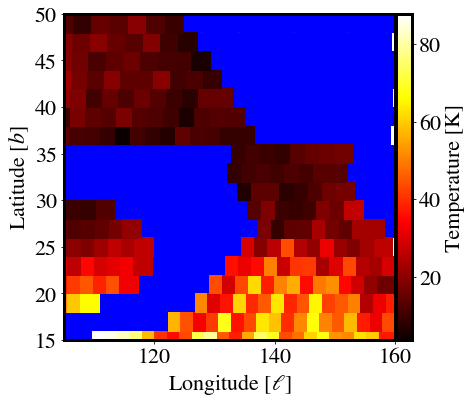

In [13]:
plt.figure(figsize=(7,6))
plt.scatter(coords[:,0], coords[:,1], s=300, marker="s", color="blue")
plt.scatter(valid_coords[:,0], valid_coords[:,1], s=350, marker="s", c=Temps, cmap="hot")
plt.xlabel("Longitude [$\\ell$]")
plt.ylabel("Latitude [$b$]")
plt.colorbar(label="Temperature [K]", pad=0.001)
plt.xlim(105, 160)
plt.ylim(15,50)
plt.show()

## Interpolate Data

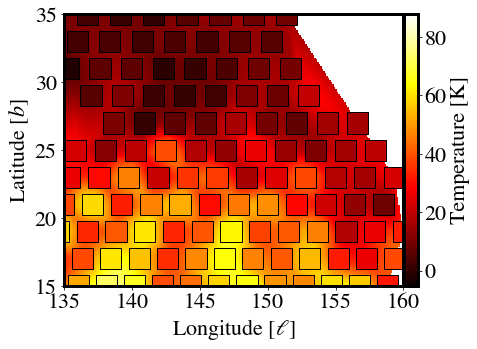

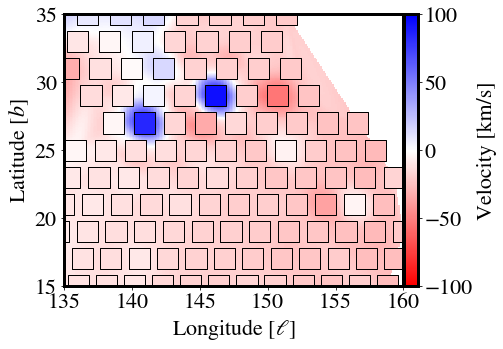

In [152]:
from scipy.interpolate import griddata
grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

xmin,xmax = 135,160
ymin,ymax = 15,35

grid = griddata(valid_coords, Temps, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], cmap="hot", aspect="equal")
ax.scatter(valid_coords
           [:,0],valid_coords[:,1], edgecolor='black',marker="s",s = 450,c=Temps, cmap="hot")
plt.colorbar(im, label="Temperature [K]", pad=0.001)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()

grid_x, grid_y = np.meshgrid(np.linspace(105,160,500),
                             np.linspace(15, 50, 500))

grid = griddata(valid_coords, vels, (grid_x, grid_y), method='cubic')

fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], 
               cmap="bwr_r", aspect="equal", vmin=-100, vmax=100)
ax.scatter(valid_coords[:,0],valid_coords[:,1], 
           edgecolor='black',marker="s",s = 450,c=vels,
           cmap="bwr_r", vmin=-100, vmax=100)
plt.colorbar(im, label="Velocity [km/s]", pad=0.001)
ax.set_xlabel("Longitude [$\\ell$]")
ax.set_ylabel("Latitude [$b$]")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.show()



In [14]:
import astropy.units as u
from astropy.coordinates import SkyCoord
gc = SkyCoord(l=valid_coords[:,0] * u.degree, b=valid_coords[:,1] * u.degree, frame='galactic')
vRAs = gc.fk5.ra.value 
vDECs = gc.fk5.dec.value

gc = SkyCoord(l=coords[:,0] * u.degree, b=coords[:,1] * u.degree, frame='galactic')
RAs = gc.fk5.ra.value 
DECs = gc.fk5.dec.value

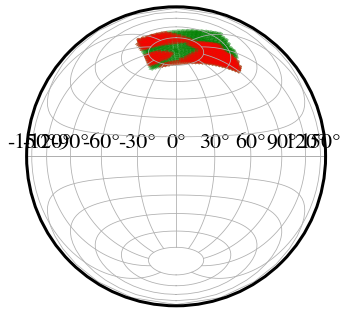

In [16]:
from matplotlib.patches import Rectangle


f = plt.figure(figsize=(9,5.5))
ax = plt.subplot(111, projection="lambert")
ax.grid(True)
for i in range(len(coords[:,0])):
    gal = SkyCoord(coords[i,0]*u.degree, coords[i,1]*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    color="green"



    

    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                             edgecolor = color,
                             facecolor = color,
                             alpha=0.5,
                             fill=True,
                             lw=3))
    
for i in range(len(valid_coords[:,0])):
    gal = SkyCoord(valid_coords[i,0]*u.degree, valid_coords[i,1]*u.degree, frame='galactic')
    ra_dec = gal.transform_to('fk5')
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    color="red"


    ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                             edgecolor = color,
                             facecolor = color,
                             alpha=0.5,
                             fill=True,
                             lw=3))
    


In [2]:
# import cartopy.feature as cfeature

# ax = plt.axis(projection=ccrs.Orthographic(0, 90))
# ax.add_feature(cfeature.LAND.with_scale('110m'))
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# plt.scatter(x=10,y=45)

In [1]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# import matplotlib.pyplot as plt

# rotated_crs = ccrs.RotatedPole(pole_longitude=120.0, pole_latitude=70.0)
# ax0 = plt.axes(projection=rotated_crs)
# ax0.set_extent([-6, 1, 47.5, 51.5], crs=ccrs.PlateCarree())
# ax0.add_feature(cfeature.LAND.with_scale('110m'))
# ax0.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

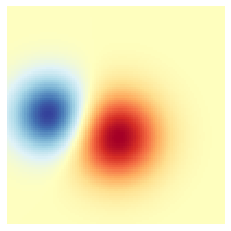

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def normal_pdf(x, mean, var):
    return np.exp(-(x - mean)**2 / (2*var))


# Generate the space in which the blobs will live
xmin, xmax, ymin, ymax = (0, 100, 0, 100)
n_bins = 100
xx = np.linspace(xmin, xmax, n_bins)
yy = np.linspace(ymin, ymax, n_bins)

# Generate the blobs. The range of the values is roughly -.0002 to .0002
means_high = [20, 50]
means_low = [50, 60]
var = [150, 200]

gauss_x_high = normal_pdf(xx, means_high[0], var[0])
gauss_y_high = normal_pdf(yy, means_high[1], var[0])

gauss_x_low = normal_pdf(xx, means_low[0], var[1])
gauss_y_low = normal_pdf(yy, means_low[1], var[1])

weights = (np.outer(gauss_y_high, gauss_x_high)
           - np.outer(gauss_y_low, gauss_x_low))

# We'll also create a grey background into which the pixels will fade
greys = np.full((*weights.shape, 3), 70, dtype=np.uint8)

# First we'll plot these blobs using ``imshow`` without transparency.
vmax = np.abs(weights).max()
imshow_kwargs = {
    'vmax': vmax,
    'vmin': -vmax,
    'cmap': 'RdYlBu',
    'extent': (xmin, xmax, ymin, ymax),
}

fig, ax = plt.subplots()
ax.imshow(greys)
ax.imshow(weights, **imshow_kwargs)
ax.set_axis_off()